# AlexNet


第一个典型的卷积神经网络是 LeNet5 ，但是第一个开启深度学习的网络却是 AlexNet，这个网络在2012年的ImageNet竞赛中取得冠军。这网络提出了深度学习常用的技术：ReLU和Dropout。AlexNet网络结构在整体上类似于LeNet，都是先卷积然后在全连接，但在细节上有很大不同，AlexNet更为复杂，Alexnet模型由5个卷积层和3个池化Pooling层，其中还有3个全连接层构成，共有$6 \times 10^7$个参数和65000个神经元，最终的输出层是1000通道的Softmax。AlexNet 跟 LeNet 结构类似，但使⽤了更多的卷积层和更⼤的参数空间来拟合⼤规模数据集 ImageNet，它是浅层神经⽹络和深度神经⽹络的分界线。


In [3]:
import torch.nn as nn
import torch
from torch.autograd import Variable


class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, init_weights=False):   
        super(AlexNet, self).__init__()
        self.features = nn.Sequential( 
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),       

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256*6*6, 4096),  #全链接
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1) #展平或者view()
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #何教授方法
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') 
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                #正态分布赋值
                nn.init.normal_(m.weight, 0, 0.01) 
                nn.init.constant_(m.bias, 0)

In [6]:
test_x = Variable(torch.zeros(1, 3, 227, 227))
net = AlexNet()
test_y = net.features(test_x)
print(test_y.shape)

torch.Size([1, 256, 6, 6])


In [5]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms as tfs
from utils import train


# 数据转换
def data_tf(x):
    im_aug = tfs.Compose([
        tfs.Resize(227),
        tfs.ToTensor(),
        tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    x = im_aug(x)
    return x
     
train_set  = CIFAR10('../../data', train=True, transform=data_tf)
train_data = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_set   = CIFAR10('../../data', train=False, transform=data_tf)
test_data  = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

In [6]:
net = AlexNet(num_classes=10)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

res = train(net, train_data, test_data, 20, optimizer, criterion, use_cuda=True)

Epoch 0. Train Loss: 1.716735, Train Acc: 0.363671, Valid Loss: 1.407991, Valid Acc: 0.488726, Time 00:01:30
Epoch 1. Train Loss: 1.358077, Train Acc: 0.511409, Valid Loss: 1.216201, Valid Acc: 0.570609, Time 00:01:46
Epoch 2. Train Loss: 1.215461, Train Acc: 0.566356, Valid Loss: 1.082299, Valid Acc: 0.616495, Time 00:01:54
Epoch 3. Train Loss: 1.127000, Train Acc: 0.601602, Valid Loss: 1.065414, Valid Acc: 0.620055, Time 00:01:44
Epoch 4. Train Loss: 1.050764, Train Acc: 0.631494, Valid Loss: 1.040739, Valid Acc: 0.636867, Time 00:01:44
Epoch 5. Train Loss: 0.986251, Train Acc: 0.652853, Valid Loss: 0.959156, Valid Acc: 0.660601, Time 00:01:44
Epoch 6. Train Loss: 0.947220, Train Acc: 0.668278, Valid Loss: 0.942900, Valid Acc: 0.670491, Time 00:01:45
Epoch 7. Train Loss: 0.909791, Train Acc: 0.682225, Valid Loss: 0.951977, Valid Acc: 0.662777, Time 00:01:45
Epoch 8. Train Loss: 0.879402, Train Acc: 0.690337, Valid Loss: 0.917556, Valid Acc: 0.678797, Time 00:01:44
Epoch 9. Train Loss

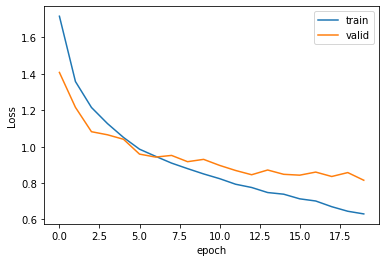

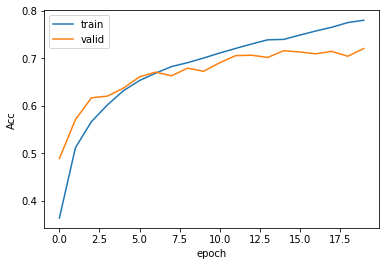

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(res[0], label='train')
plt.plot(res[2], label='valid')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.savefig('fig-res-alexnet-train-validate-loss.pdf')
plt.show()

plt.plot(res[1], label='train')
plt.plot(res[3], label='valid')
plt.xlabel('epoch')
plt.ylabel('Acc')
plt.legend(loc='best')
plt.savefig('fig-res-alexnet-train-validate-acc.pdf')
plt.show()

In [ ]:
# save raw data
import numpy
numpy.save('fig-res-alexnet_data.npy', res)